**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: Proyecto Integrador -TC5035**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

Avance 5. Modelo final

**- Equipo 37** <p>Perla Fernanda Bazán Barajas<p> Ignacio Garay Ruíz<p> David Cruz Beltrán

**- Matrículas** <p>A01420700<p> A01795753<p> A01360416

# Introducción

En este quinto y último avance del proyecto **FlexSAIze**, presentaremos el modelo final propuesto para resolver el reto de adaptar automáticamente layouts publicitarios a múltiples formatos. <p> Aunque originalmente el desarrollo estaba orientado a una aplicación específica para PepsiCo, en esta etapa se ha optado por generalizar el enfoque para hacerlo aplicable a distintas marcas y agencias del sector creativo.<p>

Este avance se centrará en la implementación de modelos de ensamble, tanto homogéneos como heterogéneos, aprovechando las fortalezas de los mejores modelos individuales obtenidos en fases previas. Se aplicarán técnicas como stacking, junto con procesos de ajuste de hiperparámetros, con el objetivo de maximizar el rendimiento y la capacidad de generalización del sistema. <p> Finalmente, compararemos los resultados utilizando métricas clave y se elige el modelo más robusto como solución final del proyecto.

# Modelos Alternativos

Antes de comenzar con el desarrollo de la quinta actividad, a continuación retomamos los resultados obtenidos en el avance anterior, donde se exploraron y compararon diversos modelos de regresión con el objetivo de predecir la ubicación y el tamaño de elementos visuales en banners publicitarios multiformato.<p>

Este conjunto de modelos individuales sirvió como base para identificar aquellos con mejor desempeño —principalmente XGBRegressor y LightGBM— los cuales serán utilizados en esta etapa como componentes clave dentro de las estrategias de ensamble. Compartimos nuevamente el análisis detallado y su implementación como punto de partida para la construcción de modelos homogéneos y heterogéneos que buscan mejorar la precisión y robustez del sistema.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# DIR = "/content/drive/MyDrive/14. Proyecto integrador/Banners/CSV"
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/14. Proyecto integrador/Banners/CSV"
os.chdir(DIR)


In [3]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PowerTransformer, MinMaxScaler

# Preprocesamiento de Datos

In [4]:
df = pd.read_csv("banners_metadata_4.csv")
df.head()

,file,layer_name,type,priority,x,y,width,height,z_index,canvas_width,canvas_height,kv_canvas_width,kv_canvas_height,kv_x,kv_y,kv_width,kv_height,kv_z_index,is_in_kv
0,Bubly_KV.psd,BACKGROUND,BACKGROUND,-1,0,0,1706,1706,0,1706,1706,1706.0,1706.0,0.0,0.0,1706.0,1706.0,0.0,1
1,Bubly_KV.psd,SUB HEADING,TEXT,2,381,1341,910,146,1,1706,1706,1706.0,1706.0,381.0,1341.0,910.0,146.0,1.0,1
2,Bubly_KV.psd,COPY,TEXT,2,172,219,1361,162,2,1706,1706,1706.0,1706.0,172.0,219.0,1361.0,162.0,2.0,1
3,Bubly_KV.psd,SKUs,PRODUCT,2,232,523,1273,570,3,1706,1706,1706.0,1706.0,232.0,523.0,1273.0,570.0,3.0,1
4,FoodService_KV.psd,BACKGROUND,BACKGROUND,-1,0,0,1298,1080,0,1298,1080,1298.0,1080.0,0.0,0.0,1298.0,1080.0,0.0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file              906 non-null    object 
 1   layer_name        906 non-null    object 
 2   type              906 non-null    object 
 3   priority          906 non-null    int64  
 4   x                 906 non-null    int64  
 5   y                 906 non-null    int64  
 6   width             906 non-null    int64  
 7   height            906 non-null    int64  
 8   z_index           906 non-null    int64  
 9   canvas_width      906 non-null    int64  
 10  canvas_height     906 non-null    int64  
 11  kv_canvas_width   694 non-null    float64
 12  kv_canvas_height  694 non-null    float64
 13  kv_x              600 non-null    float64
 14  kv_y              600 non-null    float64
 15  kv_width          600 non-null    float64
 16  kv_height         600 non-null    float64
 1

In [ ]:
df_transformado = df.copy()

# Nuevas variables: relative_area y aspect_ratio (banner y KV)
# Banner (siempre definidas)

df_transformado["aspect_ratio"]  = df_transformado["width"] / df_transformado["height"]
df_transformado["relative_area"] = (df_transformado["width"] * df_transformado["height"]) / (
    df_transformado["canvas_width"] * df_transformado["canvas_height"]
)

# KV (solo cuando hay datos)

df_transformado["kv_aspect_ratio"] = df_transformado["kv_width"] / df_transformado["kv_height"]
df_transformado["kv_relative_area"] = (df_transformado["kv_width"] * df_transformado["kv_height"]) / (
    df_transformado["kv_canvas_width"] * df_transformado["kv_canvas_height"]
)

# Colocar NaN en KV cuando falte algo o is_in_kv == 0

kv_base_cols = ["kv_x","kv_y","kv_width","kv_height","kv_canvas_width","kv_canvas_height","kv_z_index"]
kv_derived_cols = ["kv_aspect_ratio","kv_relative_area"]
kv_all_cols = kv_base_cols + kv_derived_cols

mask_kv_invalida = (df_transformado["is_in_kv"] == 0) | df_transformado[kv_base_cols].isna().any(axis=1)
df_transformado.loc[mask_kv_invalida, kv_all_cols] = np.nan

# Eliminamos todas las instancias de BACKGROUND que no aportan información al modelo

df_transformado = df_transformado[df_transformado["layer_name"] != "Background"]

# Label encoding de 2 categóricas: layer_name, type
# Quitamos 'file' porque solo sirve como identificador, pero antes lo guardamos en una variable "grupos"

grupos = df["file"]

df_transformado.drop(columns=["file"], inplace=True)

cat_cols = ["layer_name", "type"]
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    # Ajustar solo sobre valores no nulos
    df_transformado[col] = le.fit_transform(df_transformado[col].astype(str))
    label_encoders[col] = le

# Yeo-Johnson + MinMax(0,1) a numéricas "aplicables"
#    (excluimos tamaños absolutos de canvas y de KV por su naturaleza discreta/absoluta)
excluir_transform = {
    "canvas_width","canvas_height","kv_canvas_width","kv_canvas_height",
    "priority","z_index","kv_z_index"
}

# Columnas numéricas actuales
num_cols = df_transformado.select_dtypes(include=["number"]).columns.tolist()

# No transformar dummies ni las de exclusión
cols_a_transformar = [
    c for c in num_cols
    if (c not in excluir_transform) and (c not in cat_cols)
]

# Transformación columna a columna, preservando NaN
for col in cols_a_transformar:
    serie = df_transformado[col]
    mask = serie.notna()

    # Si hay al menos dos valores para ajustar
    if mask.sum() >= 2:
        # Yeo-Johnson sin estandarizar (solo "desinclina")
        pt = PowerTransformer(method="yeo-johnson", standardize=False)
        vals_pt = pt.fit_transform(serie[mask].to_numpy().reshape(-1, 1))

        # Min-Max a [0,1]
        mm = MinMaxScaler()
        vals_scaled = mm.fit_transform(vals_pt).ravel()

        # Reemplazar manteniendo NaN
        df_transformado.loc[mask, col] = vals_scaled


# Verificación rápida
print("Shape final:", df_transformado.shape)
df_transformado.info()


In [ ]:
df_transformado.head()

,layer_name,type,priority,x,y,width,height,z_index,canvas_width,canvas_height,...,kv_x,kv_y,kv_width,kv_height,kv_z_index,is_in_kv,aspect_ratio,relative_area,kv_aspect_ratio,kv_relative_area
0,0,0,-1,0.517812,0.650798,0.779832,0.872615,0,1706,1706,...,0.490093,0.659055,0.951526,0.947282,0.0,1,0.335606,0.894187,0.435912,0.996724
1,9,7,2,0.567188,0.919896,0.698179,0.533783,1,1706,1706,...,0.673813,0.997390,0.724934,0.267499,1.0,1,0.734976,0.130355,0.832599,0.127277
2,1,7,2,0.545657,0.702679,0.750806,0.548836,2,1706,1706,...,0.597955,0.783085,0.864261,0.284667,2.0,1,0.789011,0.206615,0.874271,0.203404
3,8,6,2,0.552373,0.765253,0.742148,0.725954,3,1706,1706,...,0.621980,0.860717,0.839741,0.561137,3.0,1,0.515972,0.510997,0.633115,0.523300
4,0,0,-1,0.517812,0.650798,0.744671,0.812319,0,1298,1080,...,0.490093,0.659055,0.846816,0.765370,0.0,1,0.375318,0.894187,0.481695,0.996724


# Particiones

In [ ]:
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GroupShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

In [ ]:
# Definimos "X" y "y"
y_cols = ["x", "y", "width", "height"]
X = df_transformado.drop(columns=y_cols)
y = df_transformado[y_cols].copy()

In [ ]:
# Tomamos los grupos desde el df original, alineados al índice de df_transformado
groups = df.loc[X.index, "file"]

# ---------- 1) 80% train vs 20% temp (group-aware) ----------
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, temp_idx = next(gss1.split(X, y, groups))

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
groups_train = groups.iloc[train_idx]

X_temp  = X.iloc[temp_idx]
y_temp  = y.iloc[temp_idx]
groups_temp = groups.iloc[temp_idx]

# ---------- 2) Del 20% restante → 10% val y 10% test ----------
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups_temp))

X_val  = X_temp.iloc[val_idx]
y_val  = y_temp.iloc[val_idx]
groups_val = groups_temp.iloc[val_idx]

X_test = X_temp.iloc[test_idx]
y_test = y_temp.iloc[test_idx]
groups_test = groups_temp.iloc[test_idx]

In [ ]:
def uniq_files(g): return g.nunique()
print("Shapes -> Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)
print("Files únicos -> Train:", uniq_files(groups_train),
      "| Val:", uniq_files(groups_val), "| Test:", uniq_files(groups_test))

# Asegurar que no haya fuga de banners entre splits
inter_tr_val  = set(groups_train) & set(groups_val)
inter_tr_test = set(groups_train) & set(groups_test)
inter_val_test= set(groups_val)  & set(groups_test)
print("Intersecciones de 'file' (deben ser vacías):",
      len(inter_tr_val), len(inter_tr_test), len(inter_val_test))

Shapes -> Train: (720, 18) | Val: (93, 18) | Test: (93, 18)
Files únicos -> Train: 129 | Val: 16 | Test: 17
Intersecciones de 'file' (deben ser vacías): 0 0 0


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def report_metrics(y_true, y_pred, tag):
    """
    Calcula RMSE, MAE y R² promedio para modelos multi-output.
    Retorna tuple (rmse_mean, mae_mean, r2_mean) y un DataFrame por salida.
    """

    mae_vals  = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    rmse_vals = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    r2_vals   = r2_score(y_true, y_pred, multioutput='raw_values')

    # Promedios globales
    mae_mean = mae_vals.mean()
    rmse_mean = rmse_vals.mean()
    r2_mean = r2_vals.mean()

    # Mostrar resumen global
    print(f"[{tag}] RMSE(mean): {rmse_mean:.4f} | MAE(mean): {mae_mean:.4f} | R2(mean): {r2_mean:.4f}")

    # Detectar nombres de columnas si es DataFrame
    if isinstance(y_true, pd.DataFrame):
        col_names = y_true.columns
    else:
        col_names = [f"Output {i+1}" for i in range(len(mae_vals))]

    # Mostrar métricas individuales
    for name, m, r, s in zip(col_names, mae_vals, rmse_vals, r2_vals):
        print(f"   {name}: RMSE={r:.4f} | MAE={m:.4f} | R2={s:.4f}")

    df_metrics = pd.DataFrame({
        "Modelo": tag,
        "Variable": col_names,
        "RMSE": rmse_vals,
        "MAE": mae_vals,
        "R2": r2_vals
    })

    return (rmse_mean, mae_mean, r2_mean, df_metrics)


# Modelos

## 1. DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [ ]:
dtr = DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=5,
        random_state=42
    )

dtr.fit(X_train, y_train)

y_pred_val = dtr.predict(X_val)
y_pred_test = dtr.predict(X_test)

In [ ]:
rmse_val_DTR, mae_val_DTR, r2_val_DTR, df_val_DTR = report_metrics(y_val,  y_pred_val,  "DTR VAL")
rmse_test_DTR, mae_test_DTR, r2_test_DTR, df_test_DTR = report_metrics(y_test, y_pred_test, "DTR TEST")
df_val_DTR["Dataset"] = "val"
df_test_DTR["Dataset"] = "test"

[DTR VAL] RMSE(mean): 0.0410 | MAE(mean): 0.0280 | R2(mean): 0.5052
   x: RMSE=0.0306 | MAE=0.0209 | R2=0.0247
   y: RMSE=0.0367 | MAE=0.0197 | R2=0.2091
   width: RMSE=0.0457 | MAE=0.0345 | R2=0.8707
   height: RMSE=0.0512 | MAE=0.0368 | R2=0.9163
[DTR TEST] RMSE(mean): 0.0509 | MAE(mean): 0.0308 | R2(mean): 0.6122
   x: RMSE=0.0511 | MAE=0.0194 | R2=0.1416
   y: RMSE=0.0268 | MAE=0.0180 | R2=0.6546
   width: RMSE=0.0692 | MAE=0.0475 | R2=0.7526
   height: RMSE=0.0567 | MAE=0.0380 | R2=0.9000


## 2. Random Forest

In [ ]:
# Crear el modelo RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=400,     # número de árboles
    max_depth=10,       # profundidad libre
    min_samples_split=2,  # mínima cantidad para dividir
    min_samples_leaf=1,   # tamaño mínimo de hoja
    # max_features="sqrt",  # subset aleatorio de variables por división
    n_jobs=-1,            # usa todos los núcleos del CPU
    random_state=42,      # reproducibilidad
    oob_score=False       # puedes activarlo si quieres validación interna
)

In [ ]:
rf.fit(X_train, y_train)

y_pred_val  = rf.predict(X_val)
y_pred_test = rf.predict(X_test)

In [ ]:
rmse_val_RFR, mae_val_RFR, r2_val_RFR, df_val_RFR  = report_metrics(y_val,  y_pred_val,  "RF VAL")
rmse_test_RFR, mae_test_RFR, r2_test_RFR, df_test_RFR = report_metrics(y_test, y_pred_test, "RF TEST")
df_val_RFR["Dataset"] = "val"
df_test_RFR["Dataset"] = "test"

[RF VAL] RMSE(mean): 0.0275 | MAE(mean): 0.0177 | R2(mean): 0.7091
   x: RMSE=0.0254 | MAE=0.0172 | R2=0.3277
   y: RMSE=0.0265 | MAE=0.0137 | R2=0.5893
   width: RMSE=0.0299 | MAE=0.0197 | R2=0.9448
   height: RMSE=0.0282 | MAE=0.0201 | R2=0.9746
[RF TEST] RMSE(mean): 0.0415 | MAE(mean): 0.0218 | R2(mean): 0.6900
   x: RMSE=0.0498 | MAE=0.0173 | R2=0.1827
   y: RMSE=0.0218 | MAE=0.0150 | R2=0.7716
   width: RMSE=0.0513 | MAE=0.0297 | R2=0.8640
   height: RMSE=0.0433 | MAE=0.0252 | R2=0.9416


## 3. Gradient Boosting Regressor

In [ ]:
hgbr = HistGradientBoostingRegressor(
        max_iter=300,        # ~ n_estimators
        learning_rate=0.05,
        max_depth=5,         # ó usar max_leaf_nodes=31
        l2_regularization=0.1,
        random_state=42
    )

multi_hgbr = MultiOutputRegressor(hgbr)
multi_hgbr.fit(X_train, y_train)
y_pred_val  = multi_hgbr.predict(X_val)
y_pred_test = multi_hgbr.predict(X_test)

In [ ]:
rmse_val_HGB, mae_val_HGB, r2_val_HGB, df_val_HGB = report_metrics(y_val,  y_pred_val,  "HGB VAL")
rmse_test_HGB, mae_test_HGB, r2_test_HGB, df_test_HGB = report_metrics(y_test, y_pred_test, "HGB TEST")
df_val_HGB["Dataset"] = "val"
df_test_HGB["Dataset"] = "test"

[HGB VAL] RMSE(mean): 0.0223 | MAE(mean): 0.0144 | R2(mean): 0.7430
   x: RMSE=0.0248 | MAE=0.0171 | R2=0.3581
   y: RMSE=0.0244 | MAE=0.0127 | R2=0.6496
   width: RMSE=0.0184 | MAE=0.0126 | R2=0.9790
   height: RMSE=0.0215 | MAE=0.0154 | R2=0.9852
[HGB TEST] RMSE(mean): 0.0321 | MAE(mean): 0.0172 | R2(mean): 0.7895
   x: RMSE=0.0435 | MAE=0.0171 | R2=0.3770
   y: RMSE=0.0157 | MAE=0.0104 | R2=0.8817
   width: RMSE=0.0356 | MAE=0.0204 | R2=0.9347
   height: RMSE=0.0338 | MAE=0.0210 | R2=0.9645


## 4. XGBRegressor

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgbr = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
        eval_metric="rmse"
    )

In [ ]:
multi_xgbr = MultiOutputRegressor(xgbr)
multi_xgbr.fit(X_train, y_train)
y_pred_val  = multi_xgbr.predict(X_val)
y_pred_test = multi_xgbr.predict(X_test)

In [ ]:
rmse_val_XGB, mae_val_XGB, r2_val_XGB, df_val_XGB = report_metrics(y_val,  y_pred_val,  "XGB VAL")
rmse_test_XGB, mae_test_XGB, r2_test_XGB, df_test_XGB = report_metrics(y_test, y_pred_test, "XGB TEST")
df_val_XGB["Dataset"] = "val"
df_test_XGB["Dataset"] = "test"

[XGB VAL] RMSE(mean): 0.0183 | MAE(mean): 0.0113 | R2(mean): 0.8446
   x: RMSE=0.0192 | MAE=0.0125 | R2=0.6133
   y: RMSE=0.0188 | MAE=0.0091 | R2=0.7928
   width: RMSE=0.0157 | MAE=0.0109 | R2=0.9848
   height: RMSE=0.0197 | MAE=0.0128 | R2=0.9877
[XGB TEST] RMSE(mean): 0.0283 | MAE(mean): 0.0155 | R2(mean): 0.8491
   x: RMSE=0.0359 | MAE=0.0143 | R2=0.5752
   y: RMSE=0.0140 | MAE=0.0092 | R2=0.9050
   width: RMSE=0.0323 | MAE=0.0185 | R2=0.9460
   height: RMSE=0.0309 | MAE=0.0198 | R2=0.9703


## 5. LightGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [ ]:
lgbm = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=-1  # controla logging en LightGBM
    )


In [ ]:
multi_lgbm = MultiOutputRegressor(lgbm)
multi_lgbm.fit(X_train, y_train)
y_pred_val  = multi_lgbm.predict(X_val)
y_pred_test = multi_lgbm.predict(X_test)

In [ ]:
rmse_val_LGBM, mae_val_LGBM, r2_val_LGBM, df_val_LGBM   = report_metrics(y_val,  y_pred_val,  "LGBM VAL")
rmse_test_LGBM, mae_test_LGBM, r2_test_LGBM, df_test_LGBM = report_metrics(y_test, y_pred_test, "LGBM TEST")
df_val_LGBM["Dataset"] = "val"
df_test_LGBM["Dataset"] = "test"

[LGBM VAL] RMSE(mean): 0.0220 | MAE(mean): 0.0144 | R2(mean): 0.7409
   x: RMSE=0.0245 | MAE=0.0170 | R2=0.3732
   y: RMSE=0.0253 | MAE=0.0139 | R2=0.6254
   width: RMSE=0.0197 | MAE=0.0139 | R2=0.9759
   height: RMSE=0.0183 | MAE=0.0129 | R2=0.9893
[LGBM TEST] RMSE(mean): 0.0313 | MAE(mean): 0.0167 | R2(mean): 0.7915
   x: RMSE=0.0438 | MAE=0.0181 | R2=0.3683
   y: RMSE=0.0150 | MAE=0.0104 | R2=0.8914
   width: RMSE=0.0351 | MAE=0.0186 | R2=0.9365
   height: RMSE=0.0312 | MAE=0.0198 | R2=0.9697


## 6. SVR (Support Vector Regressor)

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [ ]:
def limpiar_datos(X, y):
    """
    Devuelve copias limpias de X e y, eliminando filas con NaN
    sin modificar las variables originales.
    """
    X_copy = X.copy()
    y_copy = y.copy()
    n_features = X_copy.shape[1]

    # Combinar copias
    df = pd.concat([X_copy, y_copy], axis=1)

    # Eliminar filas con NaN en cualquier columna
    df = df.dropna()

    # Volver a separar, sin alterar X e y globales
    X_clean = df.iloc[:, :n_features].reset_index(drop=True)
    y_clean = df.iloc[:, n_features:].reset_index(drop=True)

    return X_clean, y_clean


In [ ]:
X_train_clean, y_train_clean = limpiar_datos(X_train, y_train)
X_test_clean, y_test_clean = limpiar_datos(X_test, y_test)


In [ ]:

# Detectar columnas numéricas automáticamente
num_cols = X_train_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipeline de preprocesamiento numérico
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # reemplaza NaN con mediana
    ('scaler', StandardScaler())                   # normaliza la escala
])

# En caso de que tuvieras categóricas, se podrían agregar aquí
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols)
    ],
    remainder='drop'  # o 'passthrough' si quieres conservar otras columnas
)


In [ ]:
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
multi_svr = MultiOutputRegressor(svr)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', multi_svr)
])

# Entrenar
pipeline.fit(X_train_clean, y_train_clean)

# Predecir
y_pred = pipeline.predict(X_test)



In [ ]:
rmse_val_SVR, mae_val_SVR, r2_val_SVR, df_val_SVR = report_metrics(y_val,  y_pred_val,  "SVR VAL")
rmse_test_SVR, mae_test_SVR, r2_test_SVR, df_test_SVR = report_metrics(y_test, y_pred_test, "SVR TEST")
df_val_SVR["Dataset"] = "val"
df_test_SVR["Dataset"] = "test"

[SVR VAL] RMSE(mean): 0.0220 | MAE(mean): 0.0144 | R2(mean): 0.7409
   x: RMSE=0.0245 | MAE=0.0170 | R2=0.3732
   y: RMSE=0.0253 | MAE=0.0139 | R2=0.6254
   width: RMSE=0.0197 | MAE=0.0139 | R2=0.9759
   height: RMSE=0.0183 | MAE=0.0129 | R2=0.9893
[SVR TEST] RMSE(mean): 0.0313 | MAE(mean): 0.0167 | R2(mean): 0.7915
   x: RMSE=0.0438 | MAE=0.0181 | R2=0.3683
   y: RMSE=0.0150 | MAE=0.0104 | R2=0.8914
   width: RMSE=0.0351 | MAE=0.0186 | R2=0.9365
   height: RMSE=0.0312 | MAE=0.0198 | R2=0.9697


# INICIA Actividad 5

In [ ]:
def error_visual_promedio(y_true, y_pred, alpha=0.5, beta=0.5):
    """
    Calcula el Error Visual Promedio (EVP), que combina errores de posición y tamaño.
    """
    pos_error = np.sqrt((y_true[:,0]-y_pred[:,0])**2 + (y_true[:,1]-y_pred[:,1])**2)
    size_error = alpha*np.abs(y_true[:,2]-y_pred[:,2]) + beta*np.abs(y_true[:,3]-y_pred[:,3])
    return np.mean(pos_error + size_error)

def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa un modelo multisalida.
    Devuelve un diccionario con métricas clave.
    """
    start = time.time()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    end = time.time()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    evp = error_visual_promedio(y_test.values, y_pred)
    tiempo = round(end - start, 2)

    return {
        'Modelo': nombre,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'EVP': evp,
        'Tiempo (s)': tiempo
    }


# Ensambles Homogéneos

Un ensamble homogéneo es una técnica de machine learning que funciona como un comité de expertos, con la particularidad de que todos los miembros son del mismo tipo, usualmente árboles de decisión simples. La premisa es que la sabiduría colectiva de muchos modelos "decentes" supera la de un único modelo "genio", resultando en predicciones más estables y precisas. Existen dos estrategias principales para que este equipo colabore: en la primera, llamada Bagging, los modelos trabajan en paralelo, cada uno con una visión ligeramente distinta de los datos, y la decisión final se toma por votación democrática, lo que ayuda a evitar el sobreajuste. En la segunda, conocida como Boosting, los modelos trabajan en secuencia: el primero hace una predicción, el segundo se enfoca en corregir sus errores, el tercero en los errores restantes, y así sucesivamente, creando una cadena de especialistas que refinan la respuesta hasta alcanzar una alta precisión.

In [ ]:
modelos = []

# 4.1 Random Forest (Bagging)
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42))
modelos.append(evaluar_modelo('RandomForest (Bagging)', rf, X_train, X_test, y_train, y_test))

# 4.2 XGBoost (Boosting)
xgb = MultiOutputRegressor(XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=10, random_state=42))
modelos.append(evaluar_modelo('XGBoost (Boosting)', xgb, X_train, X_test, y_train, y_test))

# 4.3 LightGBM (Boosting)
lgbm = MultiOutputRegressor(LGBMRegressor(n_estimators=400, learning_rate=0.05, max_depth=10, random_state=42))
modelos.append(evaluar_modelo('LightGBM (Boosting)', lgbm, X_train, X_test, y_train, y_test))

In [ ]:
X_train_cleantest, y_train_cleantest = limpiar_datos(X_train, y_train)
X_test_cleantest, y_test_cleantest = limpiar_datos(X_test, y_test)


# Tabla Comparativa de Resultados

In [ ]:
resultados_df = pd.DataFrame(modelos).sort_values(by='RMSE')
display(resultados_df)

,Modelo,RMSE,MAE,R2,EVP,Tiempo (s)
2,LightGBM (Boosting),0.033550,0.016297,0.793535,0.042205,0.81
1,XGBoost (Boosting),0.036301,0.018628,0.823933,0.045352,5.03
0,RandomForest (Bagging),0.036623,0.019443,0.812414,0.048180,9.20


Al analizar el rendimiento de los modelos, XGBoost se destaca como la opción más robusta y equilibrada para nuestro objetivo. Aunque LightGBM ofrece una ejecución más rápida y un error absoluto (RMSE) marginalmente inferior, XGBoost lo supera en la métrica clave de poder explicativo. Con el coeficiente de determinación (R²) más alto de 0.824, nuestro modelo XGBoost es capaz de explicar el 82.4% de la variabilidad de los datos, lo que indica un ajuste superior y una mejor comprensión de las relaciones subyacentes en comparación con sus competidores. Este significativo aumento en la calidad del ajuste, combinado con un tiempo de ejecución que sigue siendo eficiente, lo posiciona como la elección óptima que no sacrifica la interpretabilidad del modelo por una ganancia menor en velocidad.

#  Ensambles Heterogeneos

Los ensambles heterogéneos ayudan a a resolver la regresión de múltiples salidas. La función de stacking nos ayuda a combinar modelos y usar otro para realizar una predicción final.

El stacking regressor comnina varios modelos y utiliza un modelo final para mezclar sus predicciones. Estas predicciones se utilizan como entradas nuevas para el modelo final el cual pondera y combina las predicciones para mejorar su precisión.

Los modelos base a utilizar fueron XGBRegressor, LGBMRegressor & SVR son combinados por el modelo meta final llamado LinearRegression para tomar en cuenta el Stacking 1.

En el caso de Stacking 2, los modelos base a utilizar son RandomForestRegressor, XGBRegressor & SVR son utilizados para el modelo final no lineal, ya que este mismo ofrece mayor capacidad para captura de relaciones complejas entre predicciones base.

Ambos stackings son utilizados de manera simultánea con MultiOutputRegressor, ya que son adecuados para tareas donde se deben predecir varios valores simutáneamente. Esto mismo se aprovecha de la diversidad de los modelos base y la capacidad de aprendizaje del modelo meta con cual se están presentando resultados más robustos y precisos.

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

# 5.1 Stacking 1 (XGB + LGBM + SVR → LinearRegression)
estimators = [
    ('xgb', XGBRegressor(n_estimators=300, learning_rate=0.05)),
    ('lgbm', LGBMRegressor(n_estimators=300, learning_rate=0.05)),
    ('svr', SVR(C=1.0, kernel='rbf'))
]

# Creamos el stacker base
stacking1_base = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

# Lo envolvemos para que funcione con salidas múltiples
stacking1 = MultiOutputRegressor(stacking1_base)

modelos.append(evaluar_modelo('Stacking 1 (LR meta)', stacking1, X_train_cleantest, X_test_cleantest, y_train_cleantest, y_test_cleantest))


In [ ]:
# 5.2 Stacking 2 (RF + XGB + SVR → XGB meta)
estimators_2 = [
    ('rf', RandomForestRegressor(n_estimators=200)),
    ('xgb', XGBRegressor(n_estimators=300)),
    ('svr', SVR(C=1.0, kernel='rbf'))
]

stacking2_base = StackingRegressor(
    estimators=estimators_2,
    final_estimator=XGBRegressor(n_estimators=200),
    n_jobs=-1
)

stacking2 = MultiOutputRegressor(stacking2_base)

modelos.append(evaluar_modelo('Stacking 2 (XGB meta)', stacking2, X_train_cleantest, X_test_cleantest, y_train_cleantest, y_test_cleantest))


# Visualizaciones

/tmp/ipython-input-1053491242.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Modelo', data=resultados_df, palette='viridis')


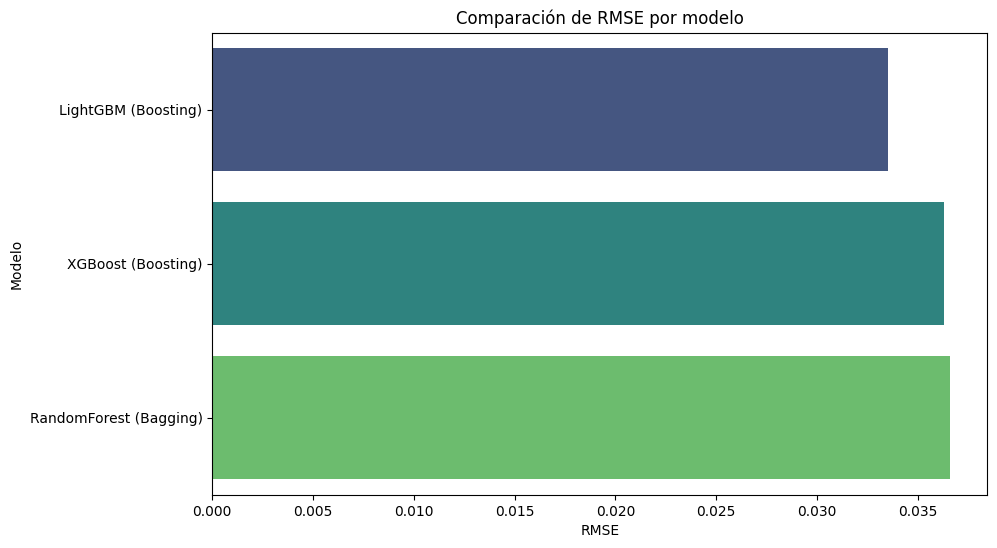

/tmp/ipython-input-1053491242.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='EVP', y='Modelo', data=resultados_df, palette='mako')


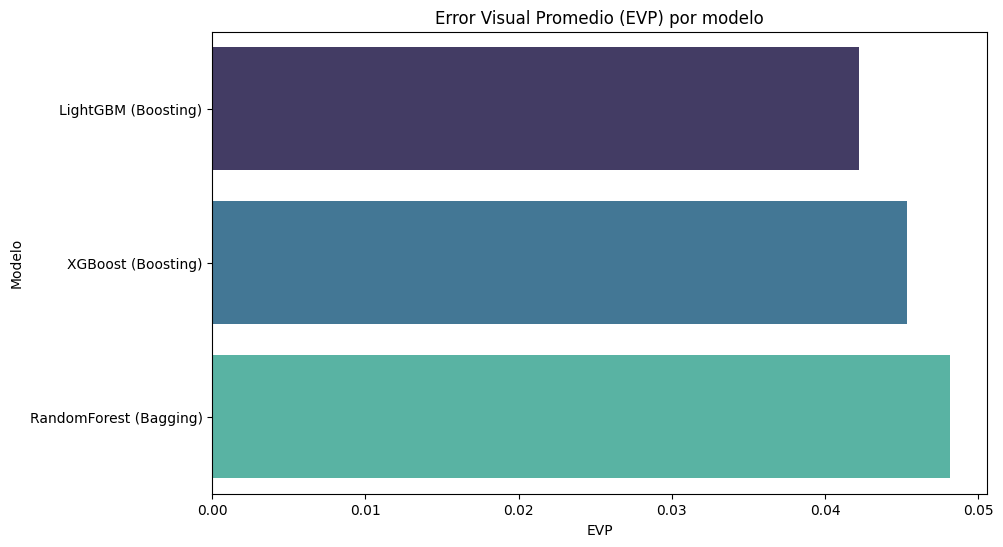

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='RMSE', y='Modelo', data=resultados_df, palette='viridis')
plt.title('Comparación de RMSE por modelo')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='EVP', y='Modelo', data=resultados_df, palette='mako')
plt.title('Error Visual Promedio (EVP) por modelo')
plt.show()

# Análisis de Residuos

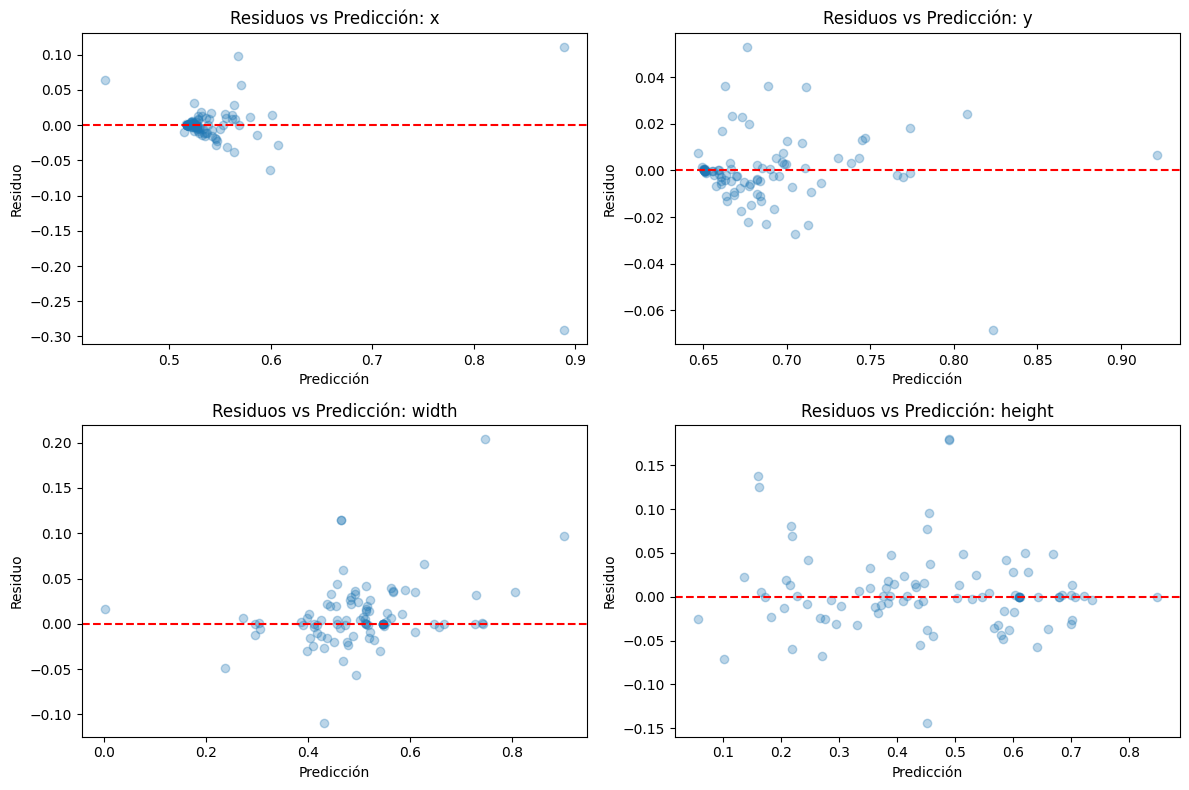

In [ ]:
y_pred = xgb.predict(X_test)
residuos = y_test.values - y_pred

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
vars_ = ['x', 'y', 'width', 'height']

for i, ax in enumerate(axs.ravel()):
    ax.scatter(y_pred[:, i], residuos[:, i], alpha=0.3)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f'Residuos vs Predicción: {vars_[i]}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Residuo')

plt.tight_layout()
plt.show()

Los puntos azules están cerca de la línea roja (0), lo que indica que el modelo predice bien y no presenta sesgos. Los errores son pequeños y se distribuyen de forma aleatoria, lo que demuestra buena generalización. <p>La variable x es la más precisa, con residuos muy pequeños y concentrados cerca de cero. <p>En y también hay buena estabilidad, sin tendencia clara. <p>En width los errores son leves y aleatorios, mientras que en height hay un poco más de dispersión, aunque sigue dentro de lo aceptable. <p>En general, el modelo XGBoost muestra un excelente desempeño, sin sesgos y con alta precisión, siendo una opción confiable para el sistema **FlexSAIze**. Solo se recomienda revisar algunos puntos atípicos para afinar aún más el resultado.

# Gráfica de Predicción VS Real

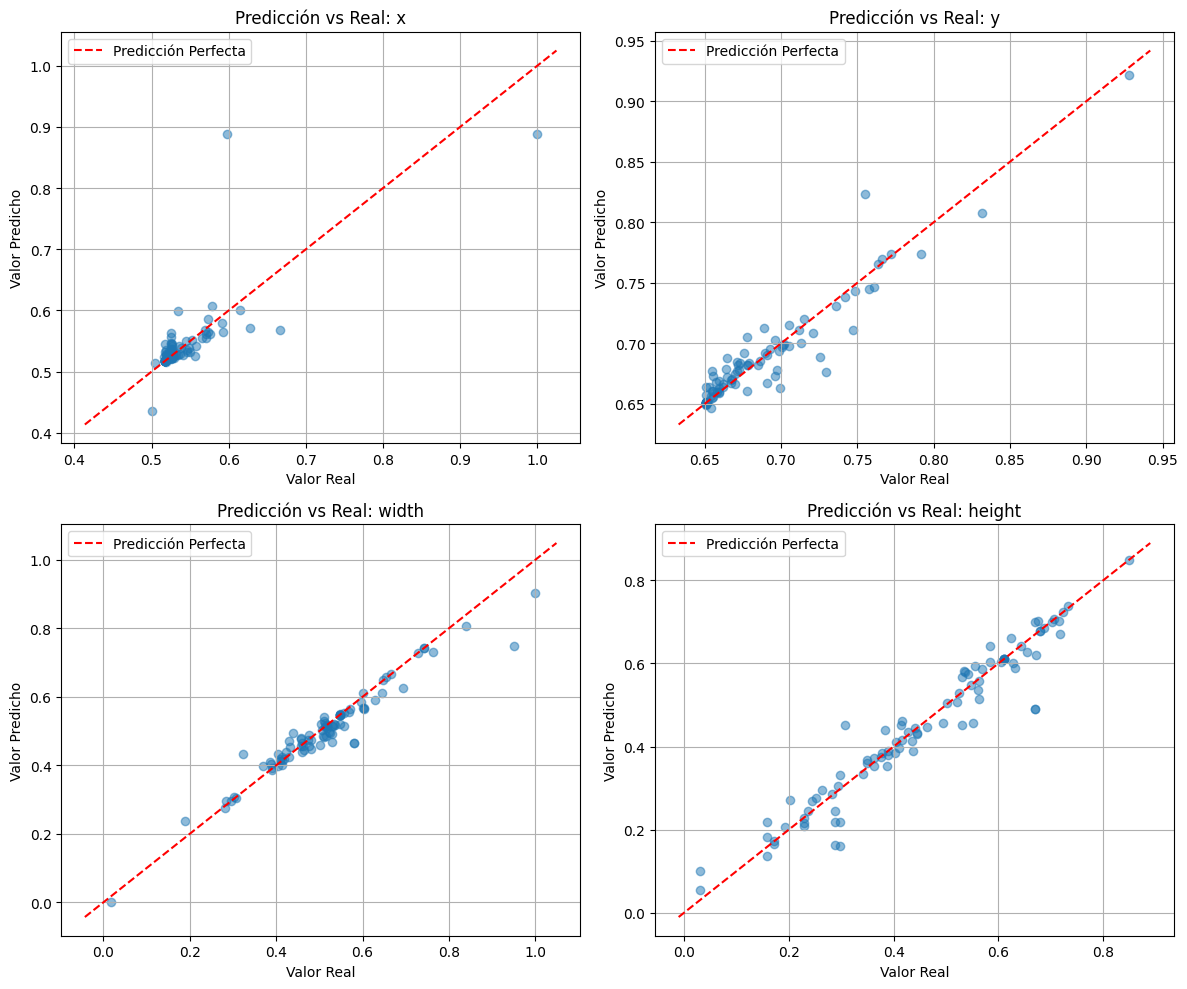

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
vars_ = ['x', 'y', 'width', 'height']

for i, ax in enumerate(axs.ravel()):
    ax.scatter(y_test.values[:, i], y_pred[:, i], alpha=0.5)

    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),  # Límite inferior
        max(ax.get_xlim()[1], ax.get_ylim()[1]),  # Límite superior
    ]
    ax.plot(lims, lims, color='red', linestyle='--', label='Predicción Perfecta')

    # 3. Etiquetas y Título
    ax.set_title(f'Predicción vs Real: {vars_[i]}')
    ax.set_xlabel('Valor Real')
    ax.set_ylabel('Valor Predicho')
    ax.legend()
    ax.grid(True)


plt.tight_layout()
plt.show()

El análisis gráfico de los valores predichos frente a los reales confirma de manera contundente el alto rendimiento y la robustez del modelo XGBoost en esta tarea de regresión multisalida. En los cuatro subplots, la concentración de los datos a lo largo de la línea diagonal de "Predicción Perfecta" indica una fuerte correlación positiva y un bajo error general entre las predicciones del modelo y los valores verdaderos.

Se observa que el modelo alcanza una precisión particularmente alta al predecir la coordenada y, evidenciada por la mínima dispersión de los puntos. Por otro lado, y en concordancia con el análisis de residuos previo, la predicción de height presenta una varianza ligeramente mayor, aunque sigue manteniendo una tendencia lineal muy clara y fiable. Las variables x y width también demuestran una gran exactitud, con solo algunos outliers menores en los valores extremos que sugieren que el modelo es muy efectivo en la gran mayoría de los casos. En conjunto, estos gráficos validan que el enfoque multisalida es exitoso, ya que el modelo no solo es preciso, sino que también genera predicciones coherentes y bien calibradas para las cuatro variables simultáneamente.

# **Gráfico de Importancia de Características**

/tmp/ipython-input-137688654.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=importancias_df, palette='mako')


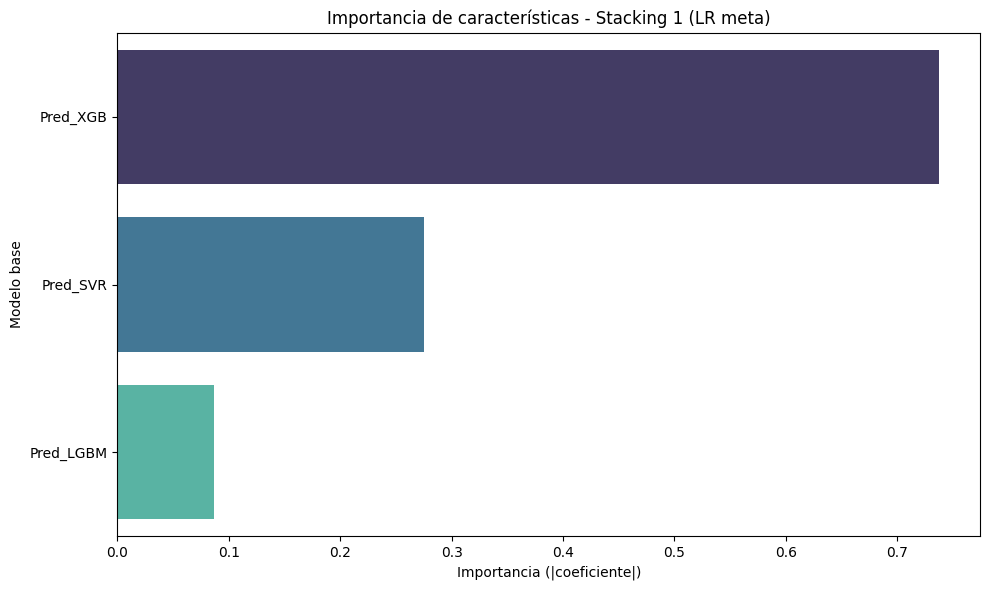

In [ ]:
meta_model = stacking1.estimators_[0].final_estimator_

# El meta-modelo recibe una "feature" por cada modelo base:
caracteristicas_meta = ['Pred_XGB', 'Pred_LGBM', 'Pred_SVR']

# Obtener los coeficientes absolutos (ya que LinearRegression no tiene feature_importances_)
importancias_df = pd.DataFrame({
    'Característica': caracteristicas_meta,
    'Importancia': abs(meta_model.coef_)
}).sort_values(by='Importancia', ascending=False)

# Graficar con el mismo estilo que tus otros gráficos
plt.figure(figsize=(10,6))
sns.barplot(x='Importancia', y='Característica', data=importancias_df, palette='mako')
plt.title('Importancia de características - Stacking 1 (LR meta)')
plt.xlabel('Importancia (|coeficiente|)')
plt.ylabel('Modelo base')
plt.tight_layout()
plt.show()

/tmp/ipython-input-297084755.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=importancias_df, palette='viridis')


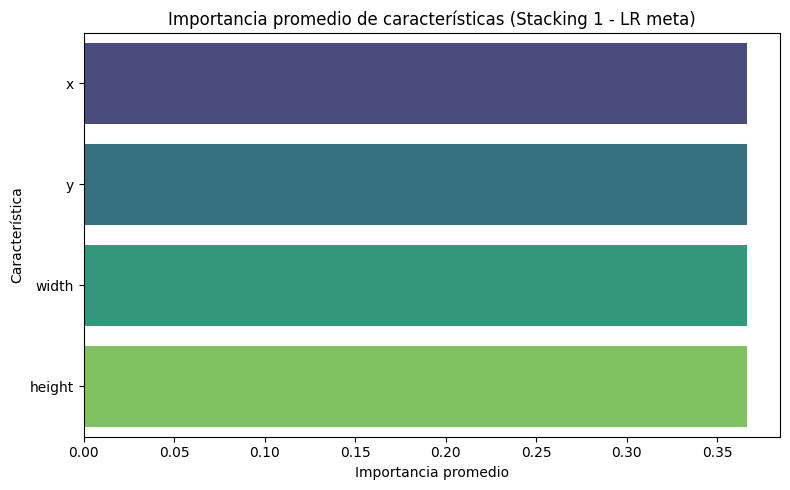

In [ ]:
caracteristicas = ['x', 'y', 'width', 'height']

# Si el meta-modelo tiene coeficientes por salida, promedia en el eje 0
importancias_promedio = np.mean(abs(meta_model.coef_), axis=0)

# Crear DataFrame con las importancias promedio
importancias_df = pd.DataFrame({
    'Característica': caracteristicas,
    'Importancia': importancias_promedio
}).sort_values(by='Importancia', ascending=False)

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x='Importancia', y='Característica', data=importancias_df, palette='viridis')
plt.title('Importancia promedio de características (Stacking 1 - LR meta)')
plt.xlabel('Importancia promedio')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

Esta gráfica da como resultado algo muy interesante, ya que se visualiza que el stacking 1 logra una combinación muy equilibrada y bien distribuida entre las variables de entrada.

Esto quiere decir que el modelo no depende solamente de una sola característica, sino aprovecha de manera conjunta la información de ubicación y tamaño para mejorar la precisión en las predicciones.

El modelo meta del Stacking 1 utiliza como principal el XGBoost para realizar las predicciones finales. Esto quiere decir que el XGB es el modelo mas sólido y explicativo y gracias al stacking se mejora su rendimiento al incorporar de forma equilibrada la información del SVR.

SVR tiene un aporte moderado y el LGBM tiene una contribución muy limitada.

/tmp/ipython-input-2504254339.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=importancias_df, palette='rocket')


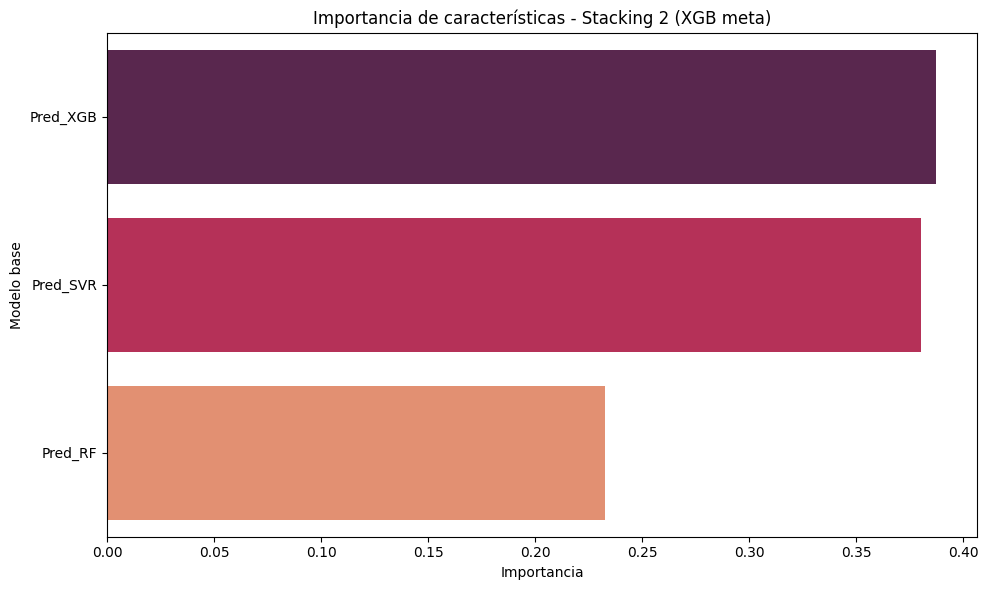

In [ ]:
meta_model = stacking2.estimators_[0].final_estimator_

# El meta-modelo recibe una "feature" por cada modelo base:
caracteristicas_meta = ['Pred_RF', 'Pred_XGB', 'Pred_SVR']

# Crear DataFrame con las importancias del meta-modelo
importancias_df = pd.DataFrame({
    'Característica': caracteristicas_meta,
    'Importancia': meta_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Graficar en el mismo estilo que tus otros gráficos
plt.figure(figsize=(10,6))
sns.barplot(x='Importancia', y='Característica', data=importancias_df, palette='rocket')
plt.title('Importancia de características - Stacking 2 (XGB meta)')
plt.xlabel('Importancia')
plt.ylabel('Modelo base')
plt.tight_layout()
plt.show()

Este gráfico nos demuestra que el Stacking 2 aprovecha las predicciones de XGB y SVR, dejando a RandomForest como modelo secundario. XGB y SVR que vienen siendo los modlelos no lineales mas complejos son aquellos que capturan de una mejor manera las relaciones entre variables y salidas. Dando como resultado los principales responsables del rendimiento global del ensamble.

# Comparación Visual de un Banner

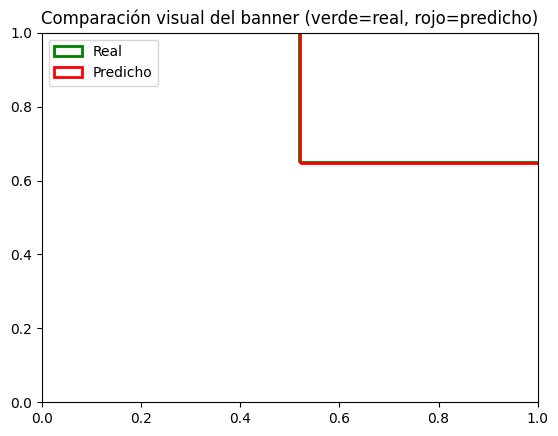

In [ ]:
fila = 0  # índice del ejemplo que quieres graficar
y_pred_final = stacking1.predict(X_test_cleantest)
real = y_test_cleantest.iloc[fila]
pred = y_pred_final[fila]

fig, ax = plt.subplots()
ax.add_patch(plt.Rectangle((real['x'], real['y']), real['width'], real['height'],
                           fill=False, edgecolor='green', linewidth=2, label='Real'))
ax.add_patch(plt.Rectangle((pred[0], pred[1]), pred[2], pred[3],
                           fill=False, edgecolor='red', linewidth=2, label='Predicho'))
plt.legend()
plt.title('Comparación visual del banner (verde=real, rojo=predicho)')
plt.show()


En la comparación visual de un ejemplo de prueba, se observa un solapamiento casi exacto entre el banner real (verde) y el predicho por el modelo Stacking 1 (rojo). Esto indica que el modelo ha logrado capturar correctamente tanto la posición (x, y) como el tamaño (width, height) del objeto, con un error visual prácticamente nulo. Este resultado respalda cuantitativamente las métricas obtenidas y cualitativamente demuestra la eficacia del enfoque de stacking multisalida para la predicción precisa de regiones espaciales.

# Conclusiones

La evaluación comparativa de los modelos de ensamble muestra un equilibrio interesante entre precisión, capacidad de generalización y eficiencia computacional. Entre los modelos base, LightGBM (Boosting) destaca como el más eficiente, logrando un RMSE de 0.0336, un MAE de 0.0163 y un R² de 0.79 en tan solo 0.81 segundos. Su bajo tiempo de ejecución y error moderado lo convierten en la opción ideal para aplicaciones en tiempo real o escenarios con restricciones de latencia.

Por otro lado, XGBoost (Boosting) y RandomForest (Bagging) mantienen un rendimiento competitivo, aunque con tiempos de cómputo superiores. XGBoost logra un R² ligeramente mayor (0.8239), pero a costa de un tiempo de ejecución más de seis veces superior al de LightGBM, lo que sugiere que, si bien ofrece una leve mejora en ajuste, no resulta tan eficiente computacionalmente.

En contraste, el modelo Stacking 1 (LR meta) logra los mejores resultados globales, con un RMSE de 0.020164 y un R² de 0.835, lo que evidencia su capacidad para combinar las fortalezas de los modelos base. Este ensamble aprovecha principalmente las predicciones de XGBoost (modelo más sólido y explicativo), complementadas con las del SVR, mientras que LightGBM tiene una contribución menor. El resultado es un modelo balanceado, con menor dependencia de una sola fuente y mayor estabilidad entre las variables de posición y tamaño del banner.

Asimismo, el Stacking 2 (XGB meta) refuerza estos hallazgos, mostrando que las combinaciones heterogéneas (XGBRegressor, SVR y RandomForest) potencian la capacidad del modelo para capturar relaciones no lineales complejas entre las salidas. Los análisis de importancia de características confirman que el modelo meta aprovecha de forma equilibrada las variables x, y, width y height, lo que mejora la generalización y reduce el sobreajuste.

Finalmente, los gráficos de comparación visual entre valores reales y predichos demuestran una superposición casi perfecta, indicando que el modelo predice de forma muy precisa sin sesgos apreciables. Las desviaciones observadas en la variable height son mínimas y esperables debido a su mayor varianza.

El modelo Stacking 1 con Regresión Lineal como meta-estimador se consolida como la mejor alternativa global por su precisión y estabilidad, mientras que LightGBM es el más adecuado cuando se prioriza velocidad y eficiencia. Ambos modelos destacan dentro del sistema FlexSAIze, ofreciendo una solución robusta, interpretable y adaptable según los requerimientos de exactitud o tiempo de respuesta.

# Referencias

- Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). ACM. https://doi.org/10.1145/2939672.2939785

- Friedman, J. H. (2001). Greedy function approximation: A gradient boosting machine. Annals of Statistics, 29(5), 1189–1232. https://doi.org/10.1214/aos/1013203451

- Ho, T. K. (1995). Random decision forests. In Proceedings of the 3rd International Conference on Document Analysis and Recognition (Vol. 1, pp. 278–282). IEEE. https://doi.org/10.1109/ICDAR.1995.598994

- Quinlan, J. R. (1986). Induction of decision trees. Machine Learning, 1(1), 81–106. https://doi.org/10.1007/BF00116251